# A2S Implementation 1 Data Analysis

In [376]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [377]:
pretest_df = pd.read_csv('data/pretest.csv')
posttest_df = pd.read_csv('data/posttest.csv')
key_df = pd.read_csv('data/key.csv')

key_df

,Question number,Question,Correct answer,Content type
0,1,Imagine you put a drop of paint in a glass of ...,free response,diffusion
1,2.1,Imagine you have a glass with hot water and an...,C,diffusion
2,2.2,Explain your choice,free response,diffusion
3,3,If you spray perfume/deodorant in the corder o...,A,diffusion
4,4,Once the perfume/deodorant particles reach the...,B,diffusion
5,5,Would the smell of perfume/deodorant make it a...,B,diffusion
6,6,The following choices are all acceptable defin...,B,modeling
7,7.1,Can a computer model represent real-world data...,B,modeling
8,7.2,Explain your choice:,free response,modeling
9,8a,Do you agree with this statement: Computer mod...,Disagree,modeling


In [378]:
all_data = pd.merge(pretest_df, posttest_df, on=["Last name", "First name", "Section", "Gender"], how="outer", suffixes=["_pre", "_post"])
# remove students not present both days
all_data = all_data[all_data.Present_pre]
all_data = all_data[all_data.Present_post]

In [379]:
# de-identify test data
student_data = all_data[["Last name", "First name", "Section", "Gender"]]
test_data = all_data.drop(["Last name", "First name", "Section", "Gender"], axis=1)

In [381]:
constrained_response = []
for index, row in key_df.iterrows():
    if row["Correct answer"] != "free response":
        constrained_response.append(row["Question number"])

In [382]:
questions_dict = {}
for question_num in constrained_response:
    question_df = test_data[[question_num + "_pre", question_num + "_post"]]
    question_df.columns = ["Pretest response", "Posttest response"]
    
    # mark correct/incorrect
    correct_response = key_df.loc[key_df["Question number"] == question_num]["Correct answer"].item()
    question_df["pre_correct"] = np.where(question_df["Pretest response"] == correct_response, True, False)
    question_df["post_correct"] = np.where(question_df["Posttest response"] == correct_response, True, False)
    
    # determine change in correctness between tests
    conditions = [question_df["pre_correct"] == question_df["post_correct"], (question_df["pre_correct"] == False) & (question_df["post_correct"] == True), (question_df["pre_correct"] == True) & (question_df["post_correct"] == False)]
    choices = ["neutral", "positive", "negative"]
    question_df["change"] = np.select(conditions, choices, default=np.nan)
    
    # add the df
    questions_dict[question_num] = question_df

/var/folders/gw/zzdm1k1s4czgdmpvkm7g_0q80000gn/T/ipykernel_62907/4076370194.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_df["pre_correct"] = np.where(question_df["Pretest response"] == correct_response, True, False)
/var/folders/gw/zzdm1k1s4czgdmpvkm7g_0q80000gn/T/ipykernel_62907/4076370194.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  question_df["post_correct"] = np.where(question_df["Posttest response"] == correct_response, True, False)
/var/folders/gw/zzdm1k1s4czgdmpvkm7g_0q80000gn

## Disagregation by question

In [383]:
summary_stats_df = pd.DataFrame(columns=['question_num', 'total_responses', 
                                         'count_pre_correct', 'percent_pre_correct', 
                                         'count_pre_incorrect', 'percent_pre_incorrect',
                                         'count_post_correct', 'percent_post_correct', 
                                         'count_post_incorrect', 'percent_post_incorrect',
                                         'count_positive_change', 'percent_positive_change',
                                         'count_negative_change', 'percent_negative_change',
                                         'count_no_change', 'percent_no_change'])

for question_num, question_df in questions_dict.items():
    total_responses = len(question_df["Pretest response"])

    count_pre_correct = len(question_df.loc[question_df["pre_correct"]])
    percent_pre_correct = count_pre_correct/total_responses
    count_pre_incorrect = len(question_df.loc[question_df["pre_correct"] == False])
    percent_pre_incorrect = count_pre_incorrect/total_responses
    
    count_post_correct = len(question_df.loc[question_df["post_correct"]])
    percent_post_correct = count_post_correct/total_responses
    count_post_incorrect = len(question_df.loc[question_df["post_correct"] == False])
    percent_post_incorrect = count_post_incorrect/total_responses

    count_positive_change = len(question_df.loc[question_df["change"] == "positive"])
    percent_positive_change = count_positive_change/total_responses
    count_negative_change = len(question_df.loc[question_df["change"] == "negative"])
    percent_negative_change = count_negative_change/total_responses
    count_no_change = len(question_df.loc[question_df["change"] == "neutral"])
    percent_no_change = count_no_change/total_responses
    
    summary_stats_df.loc[len(summary_stats_df)] = [question_num, total_responses, 
                                                  count_pre_correct, percent_pre_correct,
                                                  count_pre_incorrect, percent_pre_incorrect,
                                                  count_post_correct, percent_post_correct,
                                                  count_post_incorrect, percent_post_incorrect,
                                                  count_positive_change, percent_positive_change,
                                                  count_negative_change, percent_negative_change,
                                                  count_no_change, percent_no_change]

In [384]:
summary_stats_df

,question_num,total_responses,count_pre_correct,percent_pre_correct,count_pre_incorrect,percent_pre_incorrect,count_post_correct,percent_post_correct,count_post_incorrect,percent_post_incorrect,count_positive_change,percent_positive_change,count_negative_change,percent_negative_change,count_no_change,percent_no_change
0,2.1,43,19,0.441860,24,0.558140,39,0.906977,4,0.093023,21,0.488372,1,0.023256,21,0.488372
1,3,43,19,0.441860,24,0.558140,31,0.720930,12,0.279070,13,0.302326,1,0.023256,29,0.674419
2,4,43,9,0.209302,34,0.790698,25,0.581395,18,0.418605,18,0.418605,2,0.046512,23,0.534884
3,5,43,13,0.302326,30,0.697674,24,0.558140,19,0.441860,14,0.325581,3,0.069767,26,0.604651
4,6,43,13,0.302326,30,0.697674,23,0.534884,20,0.465116,13,0.302326,3,0.069767,27,0.627907
5,7.1,43,21,0.488372,22,0.511628,35,0.813953,8,0.186047,15,0.348837,1,0.023256,27,0.627907
6,8a,43,22,0.511628,21,0.488372,27,0.627907,16,0.372093,9,0.209302,4,0.093023,30,0.697674
7,8b,43,18,0.418605,25,0.581395,25,0.581395,18,0.418605,10,0.232558,3,0.069767,30,0.697674
8,8c,43,27,0.627907,16,0.372093,33,0.767442,10,0.232558,10,0.232558,4,0.093023,29,0.674419
9,9,43,35,0.813953,8,0.186047,43,1.000000,0,0.000000,8,0.186047,0,0.000000,35,0.813953


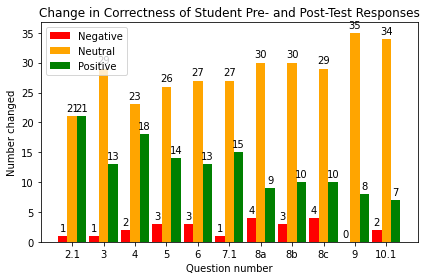

In [385]:
labels = summary_stats_df['question_num']

negative_change = summary_stats_df['count_negative_change']
no_change = summary_stats_df['count_no_change']
positive_change = summary_stats_df['count_positive_change']

x = np.arange(2*len(labels), step=2)  # the label locations
width = 0.6  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, negative_change, width, label='Negative', color="red")
rects2 = ax.bar(x, no_change, width, label='Neutral', color="orange")
rects3 = ax.bar(x + width, positive_change, width, label='Positive', color="green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number changed')
ax.set_title('Change in Correctness of Student Pre- and Post-Test Responses')
ax.set_xlabel('Question number')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
plt.show()

## Overall stats

In [386]:
pre_correct_average = summary_stats_df["count_pre_correct"].sum()/summary_stats_df["total_responses"].sum()
post_correct_average = summary_stats_df["count_post_correct"].sum()/summary_stats_df["total_responses"].sum()

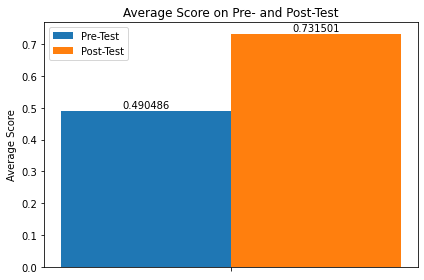

In [387]:
labels = ["Average"]

pre = [pre_correct_average]
post = [post_correct_average]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre, width, label='Pre-Test')
rects2 = ax.bar(x + width/2, post, width, label='Post-Test')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test')
ax.set_xticks(x)
ax.set_xticklabels("")
ax.legend()

ax.bar_label(rects1, padding=1)
ax.bar_label(rects2, padding=1)

fig.tight_layout()
plt.show()

## By Gender

In [388]:
girls_df = student_data.loc[student_data["Gender"] == "F"]
boys_df = student_data.loc[student_data["Gender"] == "M"]

In [389]:
# girls
summary_stats_girls_df = pd.DataFrame(columns=['question_num', 'total_responses', 
                                         'count_pre_correct', 'percent_pre_correct', 
                                         'count_pre_incorrect', 'percent_pre_incorrect',
                                         'count_post_correct', 'percent_post_correct', 
                                         'count_post_incorrect', 'percent_post_incorrect',
                                         'count_positive_change', 'percent_positive_change',
                                         'count_negative_change', 'percent_negative_change',
                                         'count_no_change', 'percent_no_change'])

for question_num, question_df in questions_dict.items():
    question_df = question_df.loc[question_df.index.isin(girls_df.index)]
    total_responses = len(question_df["Pretest response"])

    count_pre_correct = len(question_df.loc[question_df["pre_correct"]])
    percent_pre_correct = count_pre_correct/total_responses
    count_pre_incorrect = len(question_df.loc[question_df["pre_correct"] == False])
    percent_pre_incorrect = count_pre_incorrect/total_responses
    
    count_post_correct = len(question_df.loc[question_df["post_correct"]])
    percent_post_correct = count_post_correct/total_responses
    count_post_incorrect = len(question_df.loc[question_df["post_correct"] == False])
    percent_post_incorrect = count_post_incorrect/total_responses

    count_positive_change = len(question_df.loc[question_df["change"] == "positive"])
    percent_positive_change = count_positive_change/total_responses
    count_negative_change = len(question_df.loc[question_df["change"] == "negative"])
    percent_negative_change = count_negative_change/total_responses
    count_no_change = len(question_df.loc[question_df["change"] == "neutral"])
    percent_no_change = count_no_change/total_responses
    
    summary_stats_girls_df.loc[len(summary_stats_girls_df)] = [question_num, total_responses, 
                                                  count_pre_correct, percent_pre_correct,
                                                  count_pre_incorrect, percent_pre_incorrect,
                                                  count_post_correct, percent_post_correct,
                                                  count_post_incorrect, percent_post_incorrect,
                                                  count_positive_change, percent_positive_change,
                                                  count_negative_change, percent_negative_change,
                                                  count_no_change, percent_no_change]
summary_stats_girls_df

,question_num,total_responses,count_pre_correct,percent_pre_correct,count_pre_incorrect,percent_pre_incorrect,count_post_correct,percent_post_correct,count_post_incorrect,percent_post_incorrect,count_positive_change,percent_positive_change,count_negative_change,percent_negative_change,count_no_change,percent_no_change
0,2.1,18,7,0.388889,11,0.611111,16,0.888889,2,0.111111,9,0.500000,0,0.000000,9,0.500000
1,3,18,10,0.555556,8,0.444444,12,0.666667,6,0.333333,3,0.166667,1,0.055556,14,0.777778
2,4,18,5,0.277778,13,0.722222,12,0.666667,6,0.333333,7,0.388889,0,0.000000,11,0.611111
3,5,18,4,0.222222,14,0.777778,8,0.444444,10,0.555556,6,0.333333,2,0.111111,10,0.555556
4,6,18,5,0.277778,13,0.722222,9,0.500000,9,0.500000,6,0.333333,2,0.111111,10,0.555556
5,7.1,18,11,0.611111,7,0.388889,16,0.888889,2,0.111111,6,0.333333,1,0.055556,11,0.611111
6,8a,18,8,0.444444,10,0.555556,10,0.555556,8,0.444444,3,0.166667,1,0.055556,14,0.777778
7,8b,18,8,0.444444,10,0.555556,9,0.500000,9,0.500000,3,0.166667,2,0.111111,13,0.722222
8,8c,18,13,0.722222,5,0.277778,16,0.888889,2,0.111111,3,0.166667,0,0.000000,15,0.833333
9,9,18,17,0.944444,1,0.055556,18,1.000000,0,0.000000,1,0.055556,0,0.000000,17,0.944444


In [390]:
# boys
summary_stats_boys_df = pd.DataFrame(columns=['question_num', 'total_responses', 
                                         'count_pre_correct', 'percent_pre_correct', 
                                         'count_pre_incorrect', 'percent_pre_incorrect',
                                         'count_post_correct', 'percent_post_correct', 
                                         'count_post_incorrect', 'percent_post_incorrect',
                                         'count_positive_change', 'percent_positive_change',
                                         'count_negative_change', 'percent_negative_change',
                                         'count_no_change', 'percent_no_change'])
for question_num, question_df in questions_dict.items():
    question_df = question_df.loc[question_df.index.isin(boys_df.index)]
    total_responses = len(question_df["Pretest response"])

    count_pre_correct = len(question_df.loc[question_df["pre_correct"]])
    percent_pre_correct = count_pre_correct/total_responses
    count_pre_incorrect = len(question_df.loc[question_df["pre_correct"] == False])
    percent_pre_incorrect = count_pre_incorrect/total_responses
    
    count_post_correct = len(question_df.loc[question_df["post_correct"]])
    percent_post_correct = count_post_correct/total_responses
    count_post_incorrect = len(question_df.loc[question_df["post_correct"] == False])
    percent_post_incorrect = count_post_incorrect/total_responses

    count_positive_change = len(question_df.loc[question_df["change"] == "positive"])
    percent_positive_change = count_positive_change/total_responses
    count_negative_change = len(question_df.loc[question_df["change"] == "negative"])
    percent_negative_change = count_negative_change/total_responses
    count_no_change = len(question_df.loc[question_df["change"] == "neutral"])
    percent_no_change = count_no_change/total_responses
    
    summary_stats_boys_df.loc[len(summary_stats_boys_df)] = [question_num, total_responses, 
                                                  count_pre_correct, percent_pre_correct,
                                                  count_pre_incorrect, percent_pre_incorrect,
                                                  count_post_correct, percent_post_correct,
                                                  count_post_incorrect, percent_post_incorrect,
                                                  count_positive_change, percent_positive_change,
                                                  count_negative_change, percent_negative_change,
                                                  count_no_change, percent_no_change]
summary_stats_boys_df

,question_num,total_responses,count_pre_correct,percent_pre_correct,count_pre_incorrect,percent_pre_incorrect,count_post_correct,percent_post_correct,count_post_incorrect,percent_post_incorrect,count_positive_change,percent_positive_change,count_negative_change,percent_negative_change,count_no_change,percent_no_change
0,2.1,22,11,0.500000,11,0.500000,20,0.909091,2,0.090909,10,0.454545,1,0.045455,11,0.500000
1,3,22,8,0.363636,14,0.636364,16,0.727273,6,0.272727,8,0.363636,0,0.000000,14,0.636364
2,4,22,4,0.181818,18,0.818182,12,0.545455,10,0.454545,10,0.454545,2,0.090909,10,0.454545
3,5,22,7,0.318182,15,0.681818,14,0.636364,8,0.363636,8,0.363636,1,0.045455,13,0.590909
4,6,22,8,0.363636,14,0.636364,13,0.590909,9,0.409091,6,0.272727,1,0.045455,15,0.681818
5,7.1,22,8,0.363636,14,0.636364,17,0.772727,5,0.227273,9,0.409091,0,0.000000,13,0.590909
6,8a,22,13,0.590909,9,0.409091,17,0.772727,5,0.227273,6,0.272727,2,0.090909,14,0.636364
7,8b,22,9,0.409091,13,0.590909,14,0.636364,8,0.363636,6,0.272727,1,0.045455,15,0.681818
8,8c,22,13,0.590909,9,0.409091,15,0.681818,7,0.318182,6,0.272727,4,0.181818,12,0.545455
9,9,22,18,0.818182,4,0.181818,22,1.000000,0,0.000000,4,0.181818,0,0.000000,18,0.818182


In [391]:
girls_pre_correct_average = summary_stats_girls_df["count_pre_correct"].sum()/summary_stats_girls_df["total_responses"].sum()
girls_post_correct_average = summary_stats_girls_df["count_post_correct"].sum()/summary_stats_girls_df["total_responses"].sum()
boys_pre_correct_average = summary_stats_boys_df["count_pre_correct"].sum()/summary_stats_boys_df["total_responses"].sum()
boys_post_correct_average = summary_stats_boys_df["count_post_correct"].sum()/summary_stats_boys_df["total_responses"].sum()

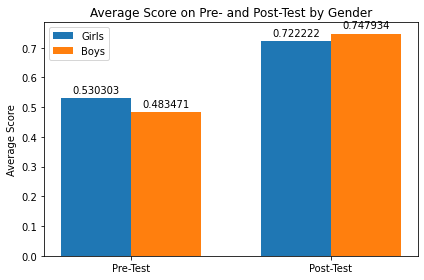

In [392]:
labels = ["Pre-Test", "Post-Test"]

girls = [girls_pre_correct_average, girls_post_correct_average]
boys = [boys_pre_correct_average, boys_post_correct_average]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, girls, width, label='Girls')
rects2 = ax.bar(x + width/2, boys, width, label='Boys')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

## By class

In [393]:
am_df = student_data.loc[student_data["Section"] == "Kmar Per, 1/2,"]
pm_df = student_data.loc[student_data["Section"] == "Vargas Per, 1/2,"]

In [394]:
# am
summary_stats_am_df = pd.DataFrame(columns=['question_num', 'total_responses', 
                                         'count_pre_correct', 'percent_pre_correct', 
                                         'count_pre_incorrect', 'percent_pre_incorrect',
                                         'count_post_correct', 'percent_post_correct', 
                                         'count_post_incorrect', 'percent_post_incorrect',
                                         'count_positive_change', 'percent_positive_change',
                                         'count_negative_change', 'percent_negative_change',
                                         'count_no_change', 'percent_no_change'])

for question_num, question_df in questions_dict.items():
    question_df = question_df.loc[question_df.index.isin(am_df.index)]
    total_responses = len(question_df["Pretest response"])

    count_pre_correct = len(question_df.loc[question_df["pre_correct"]])
    percent_pre_correct = count_pre_correct/total_responses
    count_pre_incorrect = len(question_df.loc[question_df["pre_correct"] == False])
    percent_pre_incorrect = count_pre_incorrect/total_responses
    
    count_post_correct = len(question_df.loc[question_df["post_correct"]])
    percent_post_correct = count_post_correct/total_responses
    count_post_incorrect = len(question_df.loc[question_df["post_correct"] == False])
    percent_post_incorrect = count_post_incorrect/total_responses

    count_positive_change = len(question_df.loc[question_df["change"] == "positive"])
    percent_positive_change = count_positive_change/total_responses
    count_negative_change = len(question_df.loc[question_df["change"] == "negative"])
    percent_negative_change = count_negative_change/total_responses
    count_no_change = len(question_df.loc[question_df["change"] == "neutral"])
    percent_no_change = count_no_change/total_responses
    
    summary_stats_am_df.loc[len(summary_stats_am_df)] = [question_num, total_responses, 
                                                  count_pre_correct, percent_pre_correct,
                                                  count_pre_incorrect, percent_pre_incorrect,
                                                  count_post_correct, percent_post_correct,
                                                  count_post_incorrect, percent_post_incorrect,
                                                  count_positive_change, percent_positive_change,
                                                  count_negative_change, percent_negative_change,
                                                  count_no_change, percent_no_change]
summary_stats_am_df

,question_num,total_responses,count_pre_correct,percent_pre_correct,count_pre_incorrect,percent_pre_incorrect,count_post_correct,percent_post_correct,count_post_incorrect,percent_post_incorrect,count_positive_change,percent_positive_change,count_negative_change,percent_negative_change,count_no_change,percent_no_change
0,2.1,22,12,0.545455,10,0.454545,21,0.954545,1,0.045455,9,0.409091,0,0.000000,13,0.590909
1,3,22,9,0.409091,13,0.590909,17,0.772727,5,0.227273,8,0.363636,0,0.000000,14,0.636364
2,4,22,5,0.227273,17,0.772727,14,0.636364,8,0.363636,9,0.409091,0,0.000000,13,0.590909
3,5,22,7,0.318182,15,0.681818,13,0.590909,9,0.409091,7,0.318182,1,0.045455,14,0.636364
4,6,22,10,0.454545,12,0.545455,12,0.545455,10,0.454545,4,0.181818,2,0.090909,16,0.727273
5,7.1,22,11,0.500000,11,0.500000,18,0.818182,4,0.181818,7,0.318182,0,0.000000,15,0.681818
6,8a,22,11,0.500000,11,0.500000,13,0.590909,9,0.409091,4,0.181818,2,0.090909,16,0.727273
7,8b,22,10,0.454545,12,0.545455,13,0.590909,9,0.409091,5,0.227273,2,0.090909,15,0.681818
8,8c,22,12,0.545455,10,0.454545,18,0.818182,4,0.181818,7,0.318182,1,0.045455,14,0.636364
9,9,22,20,0.909091,2,0.090909,22,1.000000,0,0.000000,2,0.090909,0,0.000000,20,0.909091


In [395]:
# pm
summary_stats_pm_df = pd.DataFrame(columns=['question_num', 'total_responses', 
                                         'count_pre_correct', 'percent_pre_correct', 
                                         'count_pre_incorrect', 'percent_pre_incorrect',
                                         'count_post_correct', 'percent_post_correct', 
                                         'count_post_incorrect', 'percent_post_incorrect',
                                         'count_positive_change', 'percent_positive_change',
                                         'count_negative_change', 'percent_negative_change',
                                         'count_no_change', 'percent_no_change'])

for question_num, question_df in questions_dict.items():
    question_df = question_df.loc[question_df.index.isin(pm_df.index)]
    total_responses = len(question_df["Pretest response"])

    count_pre_correct = len(question_df.loc[question_df["pre_correct"]])
    percent_pre_correct = count_pre_correct/total_responses
    count_pre_incorrect = len(question_df.loc[question_df["pre_correct"] == False])
    percent_pre_incorrect = count_pre_incorrect/total_responses
    
    count_post_correct = len(question_df.loc[question_df["post_correct"]])
    percent_post_correct = count_post_correct/total_responses
    count_post_incorrect = len(question_df.loc[question_df["post_correct"] == False])
    percent_post_incorrect = count_post_incorrect/total_responses

    count_positive_change = len(question_df.loc[question_df["change"] == "positive"])
    percent_positive_change = count_positive_change/total_responses
    count_negative_change = len(question_df.loc[question_df["change"] == "negative"])
    percent_negative_change = count_negative_change/total_responses
    count_no_change = len(question_df.loc[question_df["change"] == "neutral"])
    percent_no_change = count_no_change/total_responses
    
    summary_stats_pm_df.loc[len(summary_stats_pm_df)] = [question_num, total_responses, 
                                                  count_pre_correct, percent_pre_correct,
                                                  count_pre_incorrect, percent_pre_incorrect,
                                                  count_post_correct, percent_post_correct,
                                                  count_post_incorrect, percent_post_incorrect,
                                                  count_positive_change, percent_positive_change,
                                                  count_negative_change, percent_negative_change,
                                                  count_no_change, percent_no_change]
summary_stats_pm_df

,question_num,total_responses,count_pre_correct,percent_pre_correct,count_pre_incorrect,percent_pre_incorrect,count_post_correct,percent_post_correct,count_post_incorrect,percent_post_incorrect,count_positive_change,percent_positive_change,count_negative_change,percent_negative_change,count_no_change,percent_no_change
0,2.1,20,6,0.30,14,0.70,17,0.85,3,0.15,12,0.60,1,0.05,7,0.35
1,3,20,9,0.45,11,0.55,13,0.65,7,0.35,5,0.25,1,0.05,14,0.70
2,4,20,4,0.20,16,0.80,10,0.50,10,0.50,8,0.40,2,0.10,10,0.50
3,5,20,6,0.30,14,0.70,11,0.55,9,0.45,7,0.35,2,0.10,11,0.55
4,6,20,3,0.15,17,0.85,10,0.50,10,0.50,8,0.40,1,0.05,11,0.55
5,7.1,20,10,0.50,10,0.50,16,0.80,4,0.20,7,0.35,1,0.05,12,0.60
6,8a,20,11,0.55,9,0.45,13,0.65,7,0.35,4,0.20,2,0.10,14,0.70
7,8b,20,7,0.35,13,0.65,11,0.55,9,0.45,5,0.25,1,0.05,14,0.70
8,8c,20,14,0.70,6,0.30,15,0.75,5,0.25,3,0.15,2,0.10,15,0.75
9,9,20,14,0.70,6,0.30,20,1.00,0,0.00,6,0.30,0,0.00,14,0.70


In [396]:
am_pre_correct_average = summary_stats_am_df["count_pre_correct"].sum()/summary_stats_am_df["total_responses"].sum()
am_post_correct_average = summary_stats_am_df["count_post_correct"].sum()/summary_stats_am_df["total_responses"].sum()
pm_pre_correct_average = summary_stats_pm_df["count_pre_correct"].sum()/summary_stats_pm_df["total_responses"].sum()
pm_post_correct_average = summary_stats_pm_df["count_post_correct"].sum()/summary_stats_pm_df["total_responses"].sum()

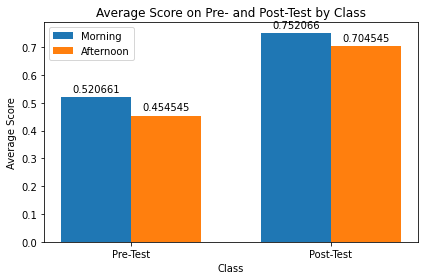

In [397]:
labels = ["Pre-Test", "Post-Test"]

am = [am_pre_correct_average, am_post_correct_average]
pm = [pm_pre_correct_average, pm_post_correct_average]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, am, width, label='Morning')
rects2 = ax.bar(x + width/2, pm, width, label='Afternoon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Class')
ax.set_xlabel('Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()

## By test

In [398]:
diffusion_df = key_df.loc[key_df["Content type"] == "diffusion"]
modeling_df = key_df.loc[key_df["Content type"] == "modeling"]
summary_stats_diffusion_df = summary_stats_df.loc[summary_stats_df.question_num.isin(diffusion_df["Question number"])]
summary_stats_modeling_df = summary_stats_df.loc[summary_stats_df.question_num.isin(modeling_df["Question number"])]

In [399]:
diffusion_pre_correct_average = summary_stats_diffusion_df["count_pre_correct"].sum()/summary_stats_diffusion_df["total_responses"].sum()
diffusion_post_correct_average = summary_stats_diffusion_df["count_post_correct"].sum()/summary_stats_diffusion_df["total_responses"].sum()
modeling_pre_correct_average = summary_stats_modeling_df["count_pre_correct"].sum()/summary_stats_modeling_df["total_responses"].sum()
modeling_post_correct_average = summary_stats_modeling_df["count_post_correct"].sum()/summary_stats_modeling_df["total_responses"].sum()

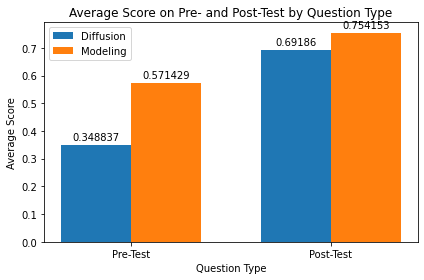

In [400]:
labels = ["Pre-Test", "Post-Test"]

diffusion = [diffusion_pre_correct_average, diffusion_post_correct_average]
modeling = [modeling_pre_correct_average, modeling_post_correct_average]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, diffusion, width, label='Diffusion')
rects2 = ax.bar(x + width/2, modeling, width, label='Modeling')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Average Score')
ax.set_title('Average Score on Pre- and Post-Test by Question Type')
ax.set_xlabel('Question Type')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.show()